In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.cluster import MiniBatchKMeans
import random
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 42
set_seed(seed)
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png')

def is_image_file(filename):
    return filename.lower().endswith(IMG_EXTENSIONS)

def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def func(dir):
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                if fname[-1] == 'g':
                    path = os.path.join(root, fname)
                    if is_image_file(path):
                        imgs.append(path)
                        labels.append(class_index)
    return imgs, labels

def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        descriptors = np.zeros((1, sift.descriptorSize()), dtype=np.float32)
    return descriptors

def extract_features(image_paths, kmeans):
    features = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        sift_features = extract_sift_features(image)
        histogram = np.zeros(kmeans.n_clusters)
        if sift_features is not None and sift_features.size > 0:
            clusters = kmeans.predict(sift_features)
            for cluster in clusters:
                histogram[cluster] += 1
        features.append(histogram)
    return np.array(features)

dir_train = "200new/200/train"
dir_test = "200new/200/test"
train_list = func(dir_train)
test_list = func(dir_test)

img = train_list[0] + test_list[0]
labels = train_list[1] + test_list[1]

# Step 1: Create the BoVW model using a subset of the training data
sift = cv2.SIFT_create()
all_descriptors = []
for image_path in img:
    image = cv2.imread(image_path)
    descriptors = extract_sift_features(image)
    if descriptors is not None:
        all_descriptors.extend(descriptors)

all_descriptors = np.array(all_descriptors)
num_clusters = 100  # Choose a suitable number of clusters
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(all_descriptors)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

best_accuracy = 0
best_fpr = None
best_tpr = None
best_roc_auc = None
best_precision = None
best_recall = None
best_pr_auc = None

for train_index, test_index in skf.split(img, labels):
    train_img_paths = [img[i] for i in train_index]
    test_img_paths = [img[i] for i in test_index]
    train_labels = [labels[i] for i in train_index]
    test_labels = [labels[i] for i in test_index]

    train_features = extract_features(train_img_paths, kmeans)
    test_features = extract_features(test_img_paths, kmeans)

    knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
    knn_model.fit(train_features, train_labels)

    test_predictions = knn_model.predict(test_features)
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Accuracy on test set: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        
        plt.figure()
        conf_matrix = confusion_matrix(test_labels, test_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=knn_model.classes_)
        disp.plot(ax=plt.gca())
        plt.title('Confusion Matrix of KNN')
        plt.savefig('KNN/SiFT/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.close()
        # 计算宏ROC曲线
        
        test_probabilities = knn_model.predict_proba(test_features)
        test_labels_bin = label_binarize(test_labels, classes=np.unique(labels))

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(test_labels_bin.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # 计算宏PR曲线
        precision, recall, pr_auc = {}, {}, {}
        for i in range(test_labels_bin.shape[1]):
            precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], test_probabilities[:, i])
            pr_auc[i] = auc(recall[i], precision[i])

        best_fpr = fpr
        best_tpr = tpr
        best_roc_auc = roc_auc
        best_precision = precision
        best_recall = recall
        best_pr_auc = pr_auc

# 存储最佳宏ROC和宏PR数据
np.save('KNN/SiFT/best_fpr.npy', best_fpr)
np.save('KNN/SiFT/best_tpr.npy', best_tpr)
np.save('KNN/SiFT/best_roc_auc.npy', best_roc_auc)
np.save('KNN/SiFT/best_precision.npy', best_precision)
np.save('KNN/SiFT/best_recall.npy', best_recall)
np.save('KNN/SiFT/best_pr_auc.npy', best_pr_auc)

print("Best macro ROC and PR curves data saved successfully.")


Accuracy on test set: 0.9388038942976356
Accuracy on test set: 0.9255910987482615
Accuracy on test set: 0.9193324061196105
Accuracy on test set: 0.9255393180236604
Accuracy on test set: 0.9227557411273486
Best macro ROC and PR curves data saved successfully.


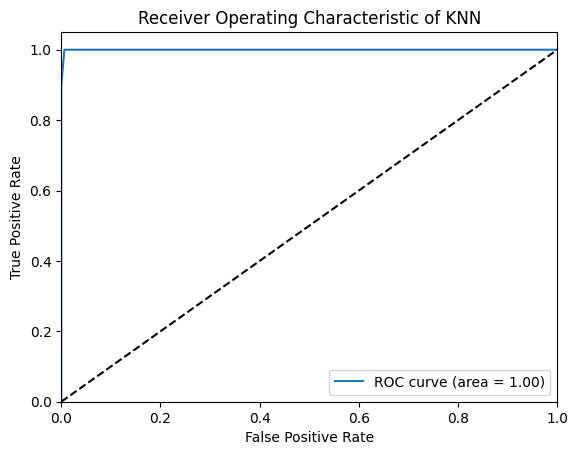

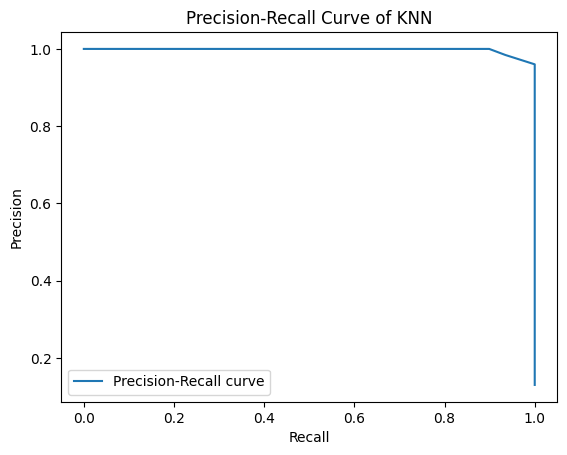

Images saved successfully.


In [5]:
from sklearn.neighbors import KNeighborsClassifier
    knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
    knn_model.fit(train_features, train_labels)

    test_predictions = knn_model.predict(test_features)
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Accuracy on test set: {accuracy}")